In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

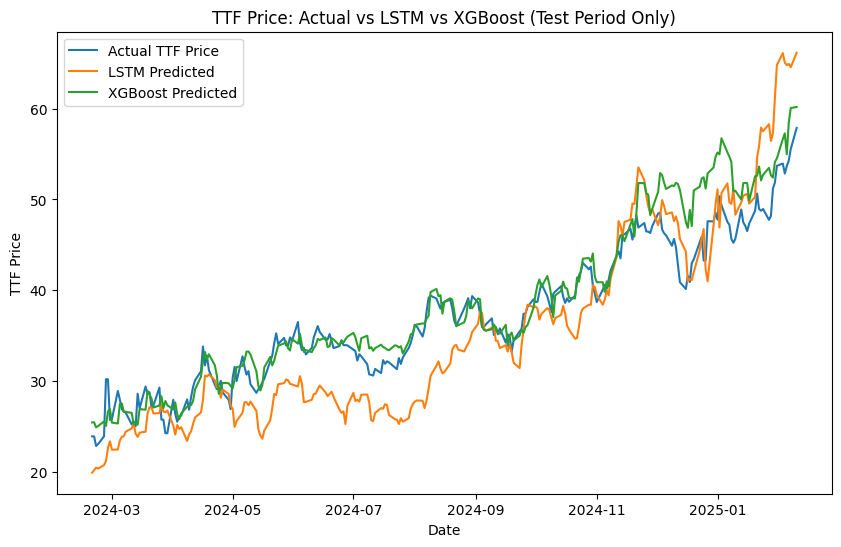

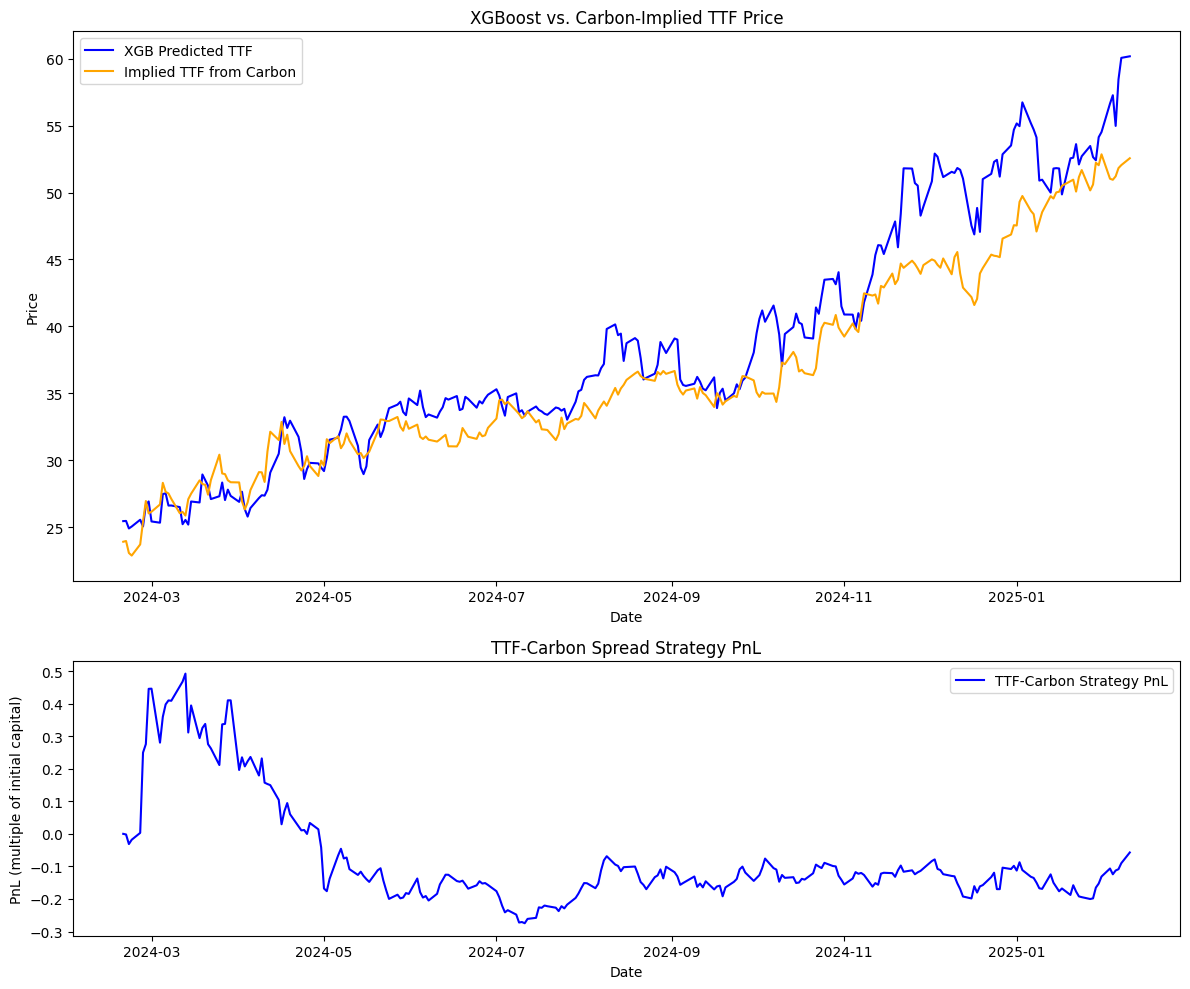

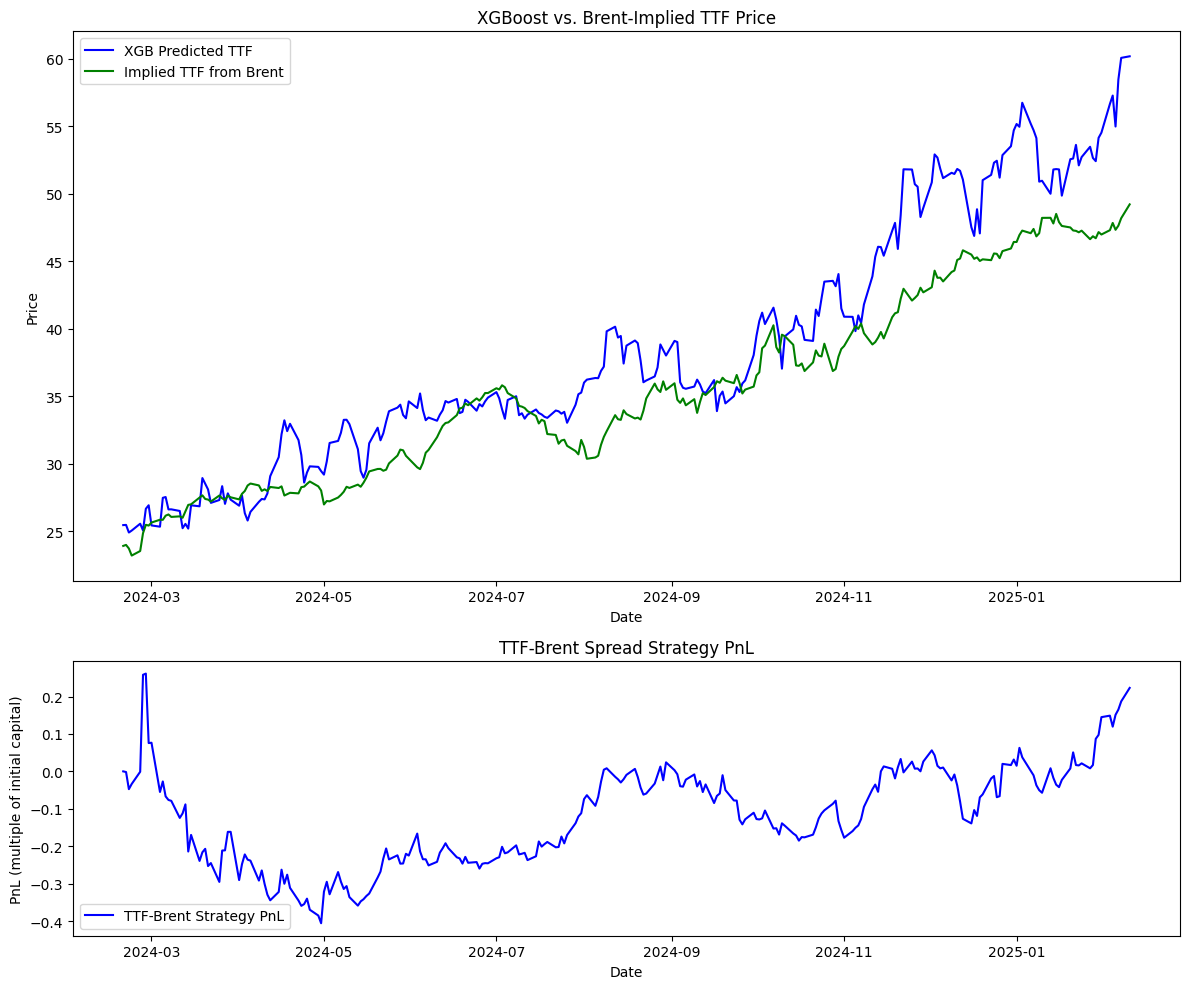

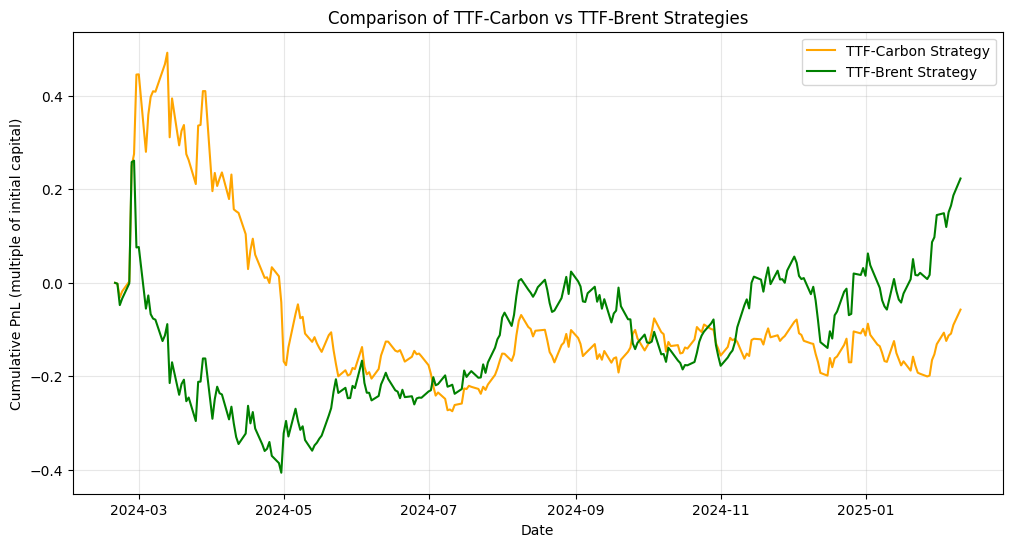

===== PERFORMANCE SUMMARY =====

CARBON STRATEGY:
Final PnL: -5.72%
Max Drawdown: -76.66%
Sharpe Ratio (Monthly): 0.17
Win Rate: 49.41%

BRENT STRATEGY:
Final PnL: 22.31%
Max Drawdown: -66.73%
Sharpe Ratio (Monthly): 0.60
Win Rate: 54.51%

Results saved to ttf_strategy_results.csv
Visualizations saved as PNG files


In [ ]:
# Load the data
df_master = pd.read_excel("master_with_lstm_and_xgb_preds.xlsx")

# 1) Initial Plot: Compare model predictions
df_test_period = df_master.dropna(subset=["lstm_predicted", "xgb_predicted"])

plt.figure(figsize=(10, 6))
plt.plot(df_test_period["Date"], df_test_period["TTF_Daily_Price"], label="Actual TTF Price")
plt.plot(df_test_period["Date"], df_test_period["lstm_predicted"], label="LSTM Predicted")
plt.plot(df_test_period["Date"], df_test_period["xgb_predicted"], label="XGBoost Predicted")
plt.title("TTF Price: Actual vs LSTM vs XGBoost (Test Period Only)")
plt.xlabel("Date")
plt.ylabel("TTF Price")
plt.legend()
plt.savefig("model_predictions_comparison.png")
plt.show()

# Working with a copy of the master dataframe
df = df_master.copy()

# Ensure Date is a datetime
df["Date"] = pd.to_datetime(df["Date"])

# Sort by date just to be safe
df.sort_values("Date", inplace=True)

# -----------------------------------------------------------------------------
# IMPLEMENTING TWO STRATEGIES: TTF-Carbon and TTF-Brent
# -----------------------------------------------------------------------------

# Check if we have the necessary columns
required_cols = ["TTF_Daily_Price", "xgb_predicted", "EUA_Euros_per_tonne", "Brent_USD_per_barrel"]
if not all(col in df.columns for col in required_cols):
    raise ValueError(f"Missing one or more required columns: {required_cols}")

# Drop any rows without needed columns
df.dropna(subset=required_cols, inplace=True)

# Calculate rolling windows for both relationships
window = 30  # rolling window for ratio

# CARBON RATIO CALCULATION
df["ttf_to_carbon_ratio"] = df["TTF_Daily_Price"] / df["EUA_Euros_per_tonne"]
df["carbon_rolling_ratio"] = df["ttf_to_carbon_ratio"].rolling(window, min_periods=1).mean()
df["carbon_implied_TTF"] = df["carbon_rolling_ratio"] * df["EUA_Euros_per_tonne"]

# BRENT RATIO CALCULATION
df["ttf_to_brent_ratio"] = df["TTF_Daily_Price"] / df["Brent_USD_per_barrel"]
df["brent_rolling_ratio"] = df["ttf_to_brent_ratio"].rolling(window, min_periods=1).mean()
df["brent_implied_TTF"] = df["brent_rolling_ratio"] * df["Brent_USD_per_barrel"]

# -----------------------------------------------------------------------------
# TRADING SIGNAL GENERATION
# -----------------------------------------------------------------------------

# We'll store the sign of the position in a column "position":
#   +1 means LONG TTF, SHORT Brent
#   -1 means SHORT TTF, LONG Brent
#    0 means no position

# We'll create two signal sets, one based on Carbon and one based on Brent
# Signal logic is the same: when model prediction > implied TTF, go long TTF

# CARBON-BASED SIGNALS
df["carbon_signal"] = 0
df.loc[df["xgb_predicted"] > df["carbon_implied_TTF"], "carbon_signal"] = 1  # Long TTF, Short Carbon
df.loc[df["xgb_predicted"] < df["carbon_implied_TTF"], "carbon_signal"] = -1  # Short TTF, Long Carbon

# BRENT-BASED SIGNALS
df["brent_signal"] = 0
df.loc[df["xgb_predicted"] > df["brent_implied_TTF"], "brent_signal"] = 1  # Long TTF, Short Brent
df.loc[df["xgb_predicted"] < df["brent_implied_TTF"], "brent_signal"] = -1  # Short TTF, Long Brent

# SHIFT the signals by 1 day to avoid look-ahead bias
df["carbon_position"] = df["carbon_signal"].shift(1).fillna(0)
df["brent_position"] = df["brent_signal"].shift(1).fillna(0)

# -----------------------------------------------------------------------------
# DYNAMIC POSITION SIZING based on price ratios
# -----------------------------------------------------------------------------

# Calculate the price ratios for position sizing
df["ttf_carbon_price_ratio"] = df["TTF_Daily_Price"] / df["EUA_Euros_per_tonne"]
df["ttf_brent_price_ratio"] = df["TTF_Daily_Price"] / df["Brent_USD_per_barrel"]

# Calculate daily returns for all assets
df["ttf_return"] = df["TTF_Daily_Price"].pct_change().fillna(0)
df["carbon_return"] = df["EUA_Euros_per_tonne"].pct_change().fillna(0)
df["brent_return"] = df["Brent_USD_per_barrel"].pct_change().fillna(0)

# Calculate spread returns with dynamic position sizing
# If TTF = €40 and Carbon = €20, we'll take double position in Carbon
df["carbon_spread_return"] = df["carbon_position"] * (
    df["ttf_return"] - (df["ttf_carbon_price_ratio"] * df["carbon_return"])
)

df["brent_spread_return"] = df["brent_position"] * (
    df["ttf_return"] - (df["ttf_brent_price_ratio"] * df["brent_return"])
)

# Calculate cumulative performance
df["carbon_cum_pnl"] = (1 + df["carbon_spread_return"]).cumprod() - 1
df["brent_cum_pnl"] = (1 + df["brent_spread_return"]).cumprod() - 1

# -----------------------------------------------------------------------------
# VISUALIZATION & ANALYSIS
# -----------------------------------------------------------------------------

# 1) CARBON strategy visualization
fig, axs = plt.subplots(2, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [2, 1]})

# Upper plot: Model vs Implied
axs[0].plot(df["Date"], df["xgb_predicted"], label="XGB Predicted TTF", color='blue')
axs[0].plot(df["Date"], df["carbon_implied_TTF"], label="Implied TTF from Carbon", color='orange')
axs[0].set_title("XGBoost vs. Carbon-Implied TTF Price")
axs[0].set_xlabel("Date")
axs[0].set_ylabel("Price")
axs[0].legend()

# Lower plot: Cumulative PnL
axs[1].plot(df["Date"], df["carbon_cum_pnl"], label="TTF-Carbon Strategy PnL", color='blue')
axs[1].set_title("TTF-Carbon Spread Strategy PnL")
axs[1].set_xlabel("Date")
axs[1].set_ylabel("PnL (multiple of initial capital)")
axs[1].legend()

plt.tight_layout()
plt.savefig("carbon_strategy_results.png")
plt.show()

# 2) BRENT strategy visualization
fig, axs = plt.subplots(2, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [2, 1]})

# Upper plot: Model vs Implied
axs[0].plot(df["Date"], df["xgb_predicted"], label="XGB Predicted TTF", color='blue')
axs[0].plot(df["Date"], df["brent_implied_TTF"], label="Implied TTF from Brent", color='green')
axs[0].set_title("XGBoost vs. Brent-Implied TTF Price")
axs[0].set_xlabel("Date")
axs[0].set_ylabel("Price")
axs[0].legend()




# Lower plot: Cumulative PnL
axs[1].plot(df["Date"], df["brent_cum_pnl"], label="TTF-Brent Strategy PnL", color='blue')
axs[1].set_title("TTF-Brent Spread Strategy PnL")
axs[1].set_xlabel("Date")
axs[1].set_ylabel("PnL (multiple of initial capital)")
axs[1].legend()

plt.tight_layout()
plt.savefig("brent_strategy_results.png")
plt.show()

# 3) COMBINED COMPARISON: Compare both strategies
plt.figure(figsize=(12, 6))
plt.plot(df["Date"], df["carbon_cum_pnl"], label="TTF-Carbon Strategy", color='orange')
plt.plot(df["Date"], df["brent_cum_pnl"], label="TTF-Brent Strategy", color='green')
plt.title("Comparison of TTF-Carbon vs TTF-Brent Strategies")
plt.xlabel("Date")
plt.ylabel("Cumulative PnL (multiple of initial capital)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig("strategy_comparison.png")
plt.show()

# -----------------------------------------------------------------------------
# PERFORMANCE METRICS
# -----------------------------------------------------------------------------

# Calculate performance metrics for Carbon strategy
carbon_final_pnl = df["carbon_cum_pnl"].iloc[-1]
df["carbon_running_max"] = df["carbon_cum_pnl"].cummax()
df["carbon_drawdown"] = df["carbon_cum_pnl"] - df["carbon_running_max"]
carbon_max_drawdown = df["carbon_drawdown"].min()

# Calculate performance metrics for Brent strategy
brent_final_pnl = df["brent_cum_pnl"].iloc[-1]
df["brent_running_max"] = df["brent_cum_pnl"].cummax()
df["brent_drawdown"] = df["brent_cum_pnl"] - df["brent_running_max"]
brent_max_drawdown = df["brent_drawdown"].min()

# Calculate monthly returns
df['YearMonth'] = df['Date'].dt.to_period('M')
carbon_monthly_returns = df.groupby('YearMonth')['carbon_spread_return'].apply(lambda x: (1 + x).prod() - 1)
brent_monthly_returns = df.groupby('YearMonth')['brent_spread_return'].apply(lambda x: (1 + x).prod() - 1)

# Calculate Sharpe Ratio (assuming risk-free rate = 0 for simplicity)
carbon_sharpe = carbon_monthly_returns.mean() / carbon_monthly_returns.std() * np.sqrt(12) if carbon_monthly_returns.std() != 0 else 0
brent_sharpe = brent_monthly_returns.mean() / brent_monthly_returns.std() * np.sqrt(12) if brent_monthly_returns.std() != 0 else 0

# Print performance summary
print(f"===== PERFORMANCE SUMMARY =====")
print(f"\nCARBON STRATEGY:")
print(f"Final PnL: {carbon_final_pnl:.2%}")
print(f"Max Drawdown: {carbon_max_drawdown:.2%}")
print(f"Sharpe Ratio (Monthly): {carbon_sharpe:.2f}")
print(f"Win Rate: {(df['carbon_spread_return'] > 0).mean():.2%}")

print(f"\nBRENT STRATEGY:")
print(f"Final PnL: {brent_final_pnl:.2%}")
print(f"Max Drawdown: {brent_max_drawdown:.2%}")
print(f"Sharpe Ratio (Monthly): {brent_sharpe:.2f}")
print(f"Win Rate: {(df['brent_spread_return'] > 0).mean():.2%}")

# Export the results to CSV for further analysis
results_df = df[['Date', 'TTF_Daily_Price', 'EUA_Euros_per_tonne', 'Brent_USD_per_barrel',
                'xgb_predicted', 'carbon_implied_TTF', 'brent_implied_TTF',
                'carbon_position', 'brent_position',
                'carbon_spread_return', 'brent_spread_return',
                'carbon_cum_pnl', 'brent_cum_pnl']]
results_df.to_csv("ttf_strategy_results.csv", index=False)

print("\nResults saved to ttf_strategy_results.csv")
print("Visualizations saved as PNG files")

# SIMULATE PNL OF THE SPREAD
###############################################################################
# We assume we enter the position (signal) at day t, hold it overnight, and exit/roll
# the next day if the signal changes. For daily PnL, we look at TTF and Brent changes.
#
# PnL_t = position_{t-1} * (Delta_TTF) - position_{t-1} * (Delta_Brent * hedge_ratio)
# We'll keep it simple and do a "1:1 ratio" in notional amounts. This is a big assumption
# in practice you'd carefully choose the hedge ratio so PnL is net of the spread move.

# SHIFT the signal by 1 day so that the signal for day t is known only after day t-1 close
# (avoid look-ahead bias). Alternatively, you might apply the same day's signal; it depends
# on how you model the actual execution. Here we do next-day entry to be safe.

# Compute daily returns for TTF and Brent
# (Percent returns or absolute changes, depending on how you want to handle notional.)

# Spread PnL. We'll do a simple approach: if position == +1 => LONG TTF, SHORT Brent
# so daily spread return ~ (ttf_return) - (brent_return).
# If position == -1 => SHORT TTF, LONG Brent => daily spread return ~ -(ttf_return) + (brent_return).

# For cumulative PnL, we do a running sum of returns.
# If we assume 1 notional unit, we can interpret spread_return as the daily % change on that notional.

<ipython-input-10-7693152ce7e4>:89: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].ffill().fillna(method='bfill')  # Forward fill then backfill if needed


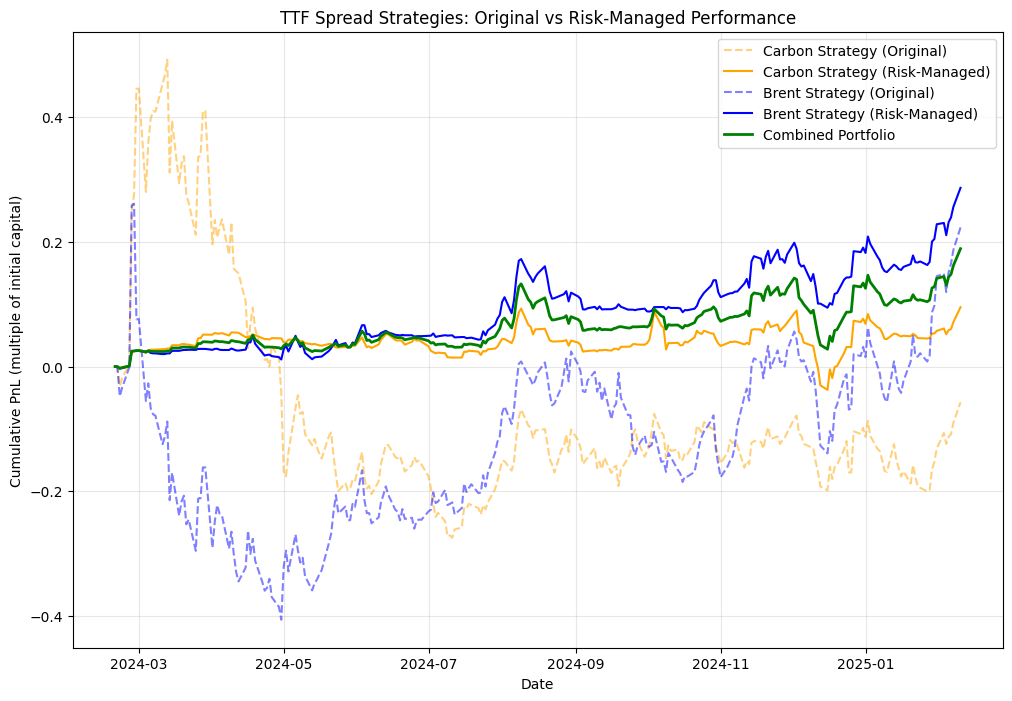

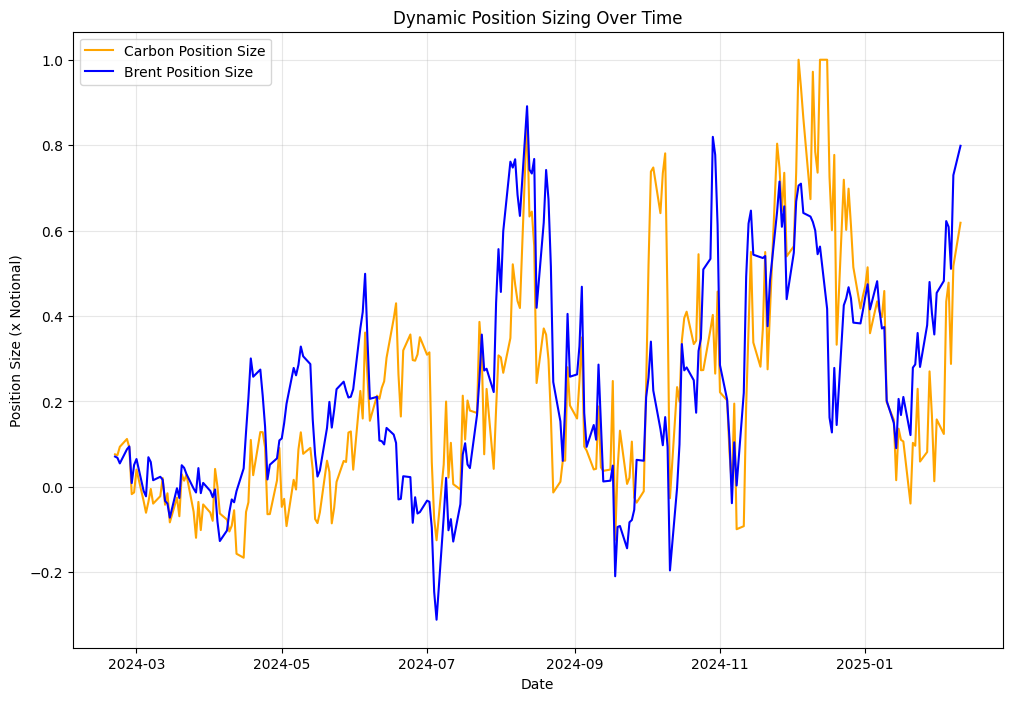

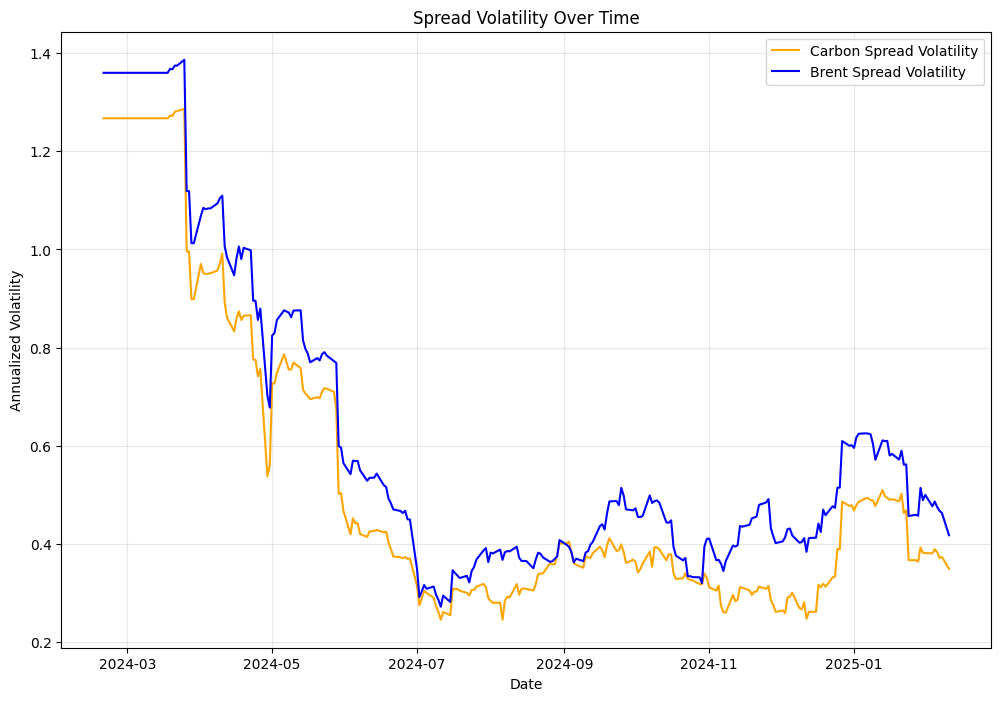

PERFORMANCE METRICS
                   Carbon Strategy Brent Strategy Combined Portfolio
Total Return                 9.52%         28.66%             18.90%
Sharpe Ratio                  0.74           1.92               1.49
Max Drawdown               -11.93%         -8.70%            -10.00%
Win Rate                    49.02%         53.73%             52.94%
Profit Factor                 1.18           1.42               1.33
Number of Trades               127            128                N/A
Avg Trade Duration        6.4 days       7.4 days                N/A

Enhanced results saved to ttf_enhanced_risk_managed_strategy.xlsx
All visualizations saved as PNG files


In [ ]:
from scipy.stats import norm




# ========================================================================
# ADJUSTABLE PARAMETERS
# ========================================================================



# Volatility calculation parameters
VOLATILITY_LOOKBACK_PERIOD = 20  # Days for rolling volatility calculation
ANNUALIZATION_FACTOR = 252       # Trading days per year for annualizing volatility




# Position sizing parameters
POSITION_SCALE = 1.5
MAX_POSITION_SIZE = 1             # Maximum leverage allowed per position
PORTFOLIO_WEIGHTS = {               # Weights for combined portfolio
    'carbon': 0.5,
    'brent': 0.5
}




# Risk management parameters
TRAILING_STOP_LOSS = 0.05  # 5% trailing stop loss




# Visualization parameters
PLOT_FIGSIZE = (12, 8)     # Default figure size for plots
PLOT_ALPHA = 0.5           # Transparency for comparison lines
PLOT_LINEWIDTH = 2         # Line width for main performance lines




# Output file names
RESULTS_FILENAME = "ttf_enhanced_risk_managed_strategy.xlsx"
PERFORMANCE_PLOT_FILENAME = "risk_managed_performance.png"
POSITION_SIZING_PLOT_FILENAME = "dynamic_position_sizing.png"
VOLATILITY_PLOT_FILENAME = "spread_volatility.png"






# -------------------------------------------------------------------------
# ENHANCED RISK MANAGEMENT & PORTFOLIO CONSTRUCTION
# -------------------------------------------------------------------------




# 1. Add volatility calculations for dynamic position sizing




# Calculate rolling volatility for each asset
df['ttf_vol'] = df['ttf_return'].rolling(VOLATILITY_LOOKBACK_PERIOD).std() * np.sqrt(ANNUALIZATION_FACTOR)
df['carbon_vol'] = df['carbon_return'].rolling(VOLATILITY_LOOKBACK_PERIOD).std() * np.sqrt(ANNUALIZATION_FACTOR)
df['brent_vol'] = df['brent_return'].rolling(VOLATILITY_LOOKBACK_PERIOD).std() * np.sqrt(ANNUALIZATION_FACTOR)




# Calculate spread volatility
df['carbon_spread_vol'] = (df['ttf_return'] - df['ttf_carbon_price_ratio'] * df['carbon_return']).rolling(VOLATILITY_LOOKBACK_PERIOD).std() * np.sqrt(ANNUALIZATION_FACTOR)
df['brent_spread_vol'] = (df['ttf_return'] - df['ttf_brent_price_ratio'] * df['brent_return']).rolling(VOLATILITY_LOOKBACK_PERIOD).std() * np.sqrt(ANNUALIZATION_FACTOR)




# Fill NaN values with a reasonable starting value
vol_cols = ['ttf_vol', 'carbon_vol', 'brent_vol',
            'carbon_spread_vol', 'brent_spread_vol']
for col in vol_cols:
    df[col] = df[col].ffill().fillna(method='bfill')  # Forward fill then backfill if needed




# 2. Calculate signal strength based on deviation between predicted and implied prices
df['carbon_signal_strength'] = abs(df['xgb_predicted'] - df['carbon_implied_TTF']) / df['carbon_implied_TTF']
df['brent_signal_strength'] = abs(df['xgb_predicted'] - df['brent_implied_TTF']) / df['brent_implied_TTF']




# 3. Dynamic Position Sizing: Adjust position sizes based on volatility and signal strength




# Scale positions inversely with volatility and proportionally with signal strength
df['carbon_pos_size'] = POSITION_SCALE / df['carbon_spread_vol'] * df['carbon_signal_strength']
df['brent_pos_size'] = POSITION_SCALE / df['brent_spread_vol'] * df['brent_signal_strength']




# Cap position sizes for risk management
df['carbon_pos_size'] = df['carbon_pos_size'].clip(0, MAX_POSITION_SIZE)
df['brent_pos_size'] = df['brent_pos_size'].clip(0, MAX_POSITION_SIZE)




# Apply position sizes to signals (and shift by 1 day)
df['carbon_sized_position'] = df['carbon_signal'].shift(1) * df['carbon_pos_size'].shift(1)
df['brent_sized_position'] = df['brent_signal'].shift(1) * df['brent_pos_size'].shift(1)




# 4. Implement Trailing Stop Loss
# Initialize columns for tracking high-water marks and stop status
for asset in ['carbon', 'brent']:
    df[f'{asset}_high_water_mark'] = 0.0
    df[f'{asset}_stop_triggered'] = False
    df[f'{asset}_risk_managed_position'] = 0.0


for asset in ['carbon', 'brent']:
    ratio_col = f'ttf_{asset}_price_ratio'
    df[f'{asset}_spread_return'] = df['ttf_return'] - (df[ratio_col] * df[f'{asset}_return'])


# Process each day for trailing stop implementation
if len(df) > 1:  # Only proceed if there are at least 2 rows
    for i in range(1, len(df)):
        for asset in ['carbon', 'brent']:
            curr_idx = df.index[i]
            prev_idx = df.index[i-1]


            position = df.loc[curr_idx, f'{asset}_sized_position']


            if position != 0:
                if df.loc[prev_idx, f'{asset}_risk_managed_position'] == 0 or df.loc[prev_idx, f'{asset}_stop_triggered']:
                    # New position, reset high water mark
                    df.loc[curr_idx, f'{asset}_high_water_mark'] = 0
                    df.loc[curr_idx, f'{asset}_stop_triggered'] = False
                else:
                    position_return = df.loc[curr_idx, f'{asset}_spread_return'] * df.loc[prev_idx, f'{asset}_risk_managed_position']
                    daily_return = position_return / abs(df.loc[prev_idx, f'{asset}_risk_managed_position']) if df.loc[prev_idx, f'{asset}_risk_managed_position'] != 0 else 0
                    # Update high water mark
                    df.loc[curr_idx, f'{asset}_high_water_mark'] = max(df.loc[prev_idx, f'{asset}_high_water_mark'] + daily_return, df.loc[prev_idx, f'{asset}_high_water_mark'])


                    # Check if stop loss is triggered
                    current_return = df.loc[prev_idx, f'{asset}_high_water_mark'] + daily_return
                    if df.loc[prev_idx, f'{asset}_high_water_mark'] - current_return > TRAILING_STOP_LOSS:
                        df.loc[curr_idx, f'{asset}_stop_triggered'] = True
                        position = 0  # Exit position
                    else:
                        df.loc[curr_idx, f'{asset}_stop_triggered'] = False


            # Store the final position after risk management
            df.loc[curr_idx, f'{asset}_risk_managed_position'] = position
else:
    print("Warning: DataFrame has too few rows to implement trailing stop loss.")
    # Just copy the sized position to risk managed position if not enough data
    for asset in ['carbon', 'brent']:
        df[f'{asset}_risk_managed_position'] = df[f'{asset}_sized_position']




# 5. Calculate returns with risk-managed positions
for asset in ['carbon', 'brent']:
    # Calculate risk-adjusted spread returns
    df[f'{asset}_risk_adjusted_return'] = df[f'{asset}_risk_managed_position'] * (
        df['ttf_return'] - (df[f'ttf_{asset}_price_ratio'] * df[f'{asset}_return'])
    )


    # Calculate cumulative risk-adjusted PnL
    df[f'{asset}_risk_adjusted_pnl'] = (1 + df[f'{asset}_risk_adjusted_return']).cumprod() - 1




# 6. Create a combined portfolio of Carbon and Brent strategies
df['combined_portfolio_return'] = (PORTFOLIO_WEIGHTS['carbon'] * df['carbon_risk_adjusted_return'] +
                                  PORTFOLIO_WEIGHTS['brent'] * df['brent_risk_adjusted_return'])
df['combined_portfolio_pnl'] = (1 + df['combined_portfolio_return']).cumprod() - 1




# -------------------------------------------------------------------------
# VISUALIZATION & PERFORMANCE ANALYSIS
# -------------------------------------------------------------------------




# 1. Plot risk-adjusted returns vs original returns
plt.figure(figsize=PLOT_FIGSIZE)
plt.plot(df['Date'], df['carbon_cum_pnl'], '--', color='orange', alpha=PLOT_ALPHA, label='Carbon Strategy (Original)')
plt.plot(df['Date'], df['carbon_risk_adjusted_pnl'], color='orange', label='Carbon Strategy (Risk-Managed)')
plt.plot(df['Date'], df['brent_cum_pnl'], '--', color='blue', alpha=PLOT_ALPHA, label='Brent Strategy (Original)')
plt.plot(df['Date'], df['brent_risk_adjusted_pnl'], color='blue', label='Brent Strategy (Risk-Managed)')
plt.plot(df['Date'], df['combined_portfolio_pnl'], color='green', linewidth=PLOT_LINEWIDTH, label='Combined Portfolio')
plt.title('TTF Spread Strategies: Original vs Risk-Managed Performance')
plt.xlabel('Date')
plt.ylabel('Cumulative PnL (multiple of initial capital)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(PERFORMANCE_PLOT_FILENAME)
plt.show()




# 2. Plot dynamic position sizes over time
plt.figure(figsize=PLOT_FIGSIZE)
plt.plot(df['Date'], df['carbon_sized_position'], color='orange', label='Carbon Position Size')
plt.plot(df['Date'], df['brent_sized_position'], color='blue', label='Brent Position Size')
plt.title('Dynamic Position Sizing Over Time')
plt.xlabel('Date')
plt.ylabel('Position Size (x Notional)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(POSITION_SIZING_PLOT_FILENAME)
plt.show()




# 3. Plot volatility over time
plt.figure(figsize=PLOT_FIGSIZE)
plt.plot(df['Date'], df['carbon_spread_vol'], color='orange', label='Carbon Spread Volatility')
plt.plot(df['Date'], df['brent_spread_vol'], color='blue', label='Brent Spread Volatility')
plt.title('Spread Volatility Over Time')
plt.xlabel('Date')
plt.ylabel('Annualized Volatility')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(VOLATILITY_PLOT_FILENAME)
plt.show()




# 4. Calculate and display enhanced performance metrics
# 4. Calculate and display enhanced performance metrics
def calculate_performance_metrics(returns, position_sizes=None):
    """Calculate comprehensive performance metrics"""
    # Drop NaN values
    returns = returns.dropna()


    # Basic metrics
    total_return = (1 + returns).prod() - 1
    annualized_return = (1 + total_return) ** (252 / len(returns)) - 1
    volatility = returns.std() * np.sqrt(252)
    sharpe = annualized_return / volatility if volatility > 0 else 0


    # Drawdown analysis
    cum_returns = (1 + returns).cumprod()
    running_max = cum_returns.cummax()
    drawdown = (cum_returns / running_max - 1)
    max_drawdown = drawdown.min()


    # Calculate number of trades if position sizes are provided
    num_trades = 0
    avg_trade_duration = 0
    if position_sizes is not None:
        # A trade starts when position changes from 0 to non-zero or changes sign
        trades = position_sizes.diff() != 0
        num_trades = trades.sum() / 2  # Divide by 2 as each trade has entry and exit


        # Average trade duration calculation
        trade_starts = []
        trade_ends = []
        in_trade = False


        for i in range(len(position_sizes)):
            if not in_trade and position_sizes.iloc[i] != 0:
                trade_starts.append(i)
                in_trade = True
            elif in_trade and (position_sizes.iloc[i] == 0 or (i > 0 and np.sign(position_sizes.iloc[i]) != np.sign(position_sizes.iloc[i-1]))):
                trade_ends.append(i)
                in_trade = False


        if in_trade:  # Add the last trade if still open
            trade_ends.append(len(position_sizes) - 1)


        if len(trade_starts) == len(trade_ends) and len(trade_starts) > 0:
            durations = [end - start for start, end in zip(trade_starts, trade_ends)]
            avg_trade_duration = sum(durations) / len(durations)


    # Win rate
    win_rate = (returns > 0).mean()


    # Profit factor
    gross_profits = returns[returns > 0].sum()
    gross_losses = abs(returns[returns < 0].sum())
    profit_factor = gross_profits / gross_losses if gross_losses != 0 else float('inf')




    # Return all metrics as a dictionary
    return {
        'Total Return': f"{total_return:.2%}",
        # 'Annualized Return': f"{annualized_return:.2%}",
        # 'Volatility': f"{volatility:.2%}",
        'Sharpe Ratio': f"{sharpe:.2f}",
        'Max Drawdown': f"{max_drawdown:.2%}",
        'Win Rate': f"{win_rate:.2%}",
        'Profit Factor': f"{profit_factor:.2f}",
        'Number of Trades': f"{num_trades:.0f}" if num_trades > 0 else "N/A",
        'Avg Trade Duration': f"{avg_trade_duration:.1f} days" if avg_trade_duration > 0 else "N/A"
    }




# Calculate metrics for all strategies
carbon_metrics = calculate_performance_metrics(df['carbon_risk_adjusted_return'], df['carbon_risk_managed_position'])
brent_metrics = calculate_performance_metrics(df['brent_risk_adjusted_return'], df['brent_risk_managed_position'])
combined_metrics = calculate_performance_metrics(df['combined_portfolio_return'])




# Create a summary dataframe
metrics_df = pd.DataFrame({
    'Carbon Strategy': pd.Series(carbon_metrics),
    'Brent Strategy': pd.Series(brent_metrics),
    'Combined Portfolio': pd.Series(combined_metrics)
})




# 4. Calculate and display enhanced performance metrics
# 4. Calculate and display enhanced performance metrics
def calculate_performance_metrics(returns, position_sizes=None):
    """Calculate comprehensive performance metrics"""
    # Drop NaN values
    returns = returns.dropna()


    # Basic metrics
    total_return = (1 + returns).prod() - 1
    annualized_return = (1 + total_return) ** (252 / len(returns)) - 1
    volatility = returns.std() * np.sqrt(252)
    sharpe = annualized_return / volatility if volatility > 0 else 0


    # Drawdown analysis
    cum_returns = (1 + returns).cumprod()
    running_max = cum_returns.cummax()
    drawdown = (cum_returns / running_max - 1)
    max_drawdown = drawdown.min()


    # Calculate number of trades if position sizes are provided
    num_trades = 0
    avg_trade_duration = 0
    if position_sizes is not None:
        # A trade starts when position changes from 0 to non-zero or changes sign
        trades = position_sizes.diff() != 0
        num_trades = trades.sum() / 2  # Divide by 2 as each trade has entry and exit


        # Average trade duration calculation
        trade_starts = []
        trade_ends = []
        in_trade = False


        for i in range(len(position_sizes)):
            if not in_trade and position_sizes.iloc[i] != 0:
                trade_starts.append(i)
                in_trade = True
            elif in_trade and (position_sizes.iloc[i] == 0 or (i > 0 and np.sign(position_sizes.iloc[i]) != np.sign(position_sizes.iloc[i-1]))):
                trade_ends.append(i)
                in_trade = False


        if in_trade:  # Add the last trade if still open
            trade_ends.append(len(position_sizes) - 1)


        if len(trade_starts) == len(trade_ends) and len(trade_starts) > 0:
            durations = [end - start for start, end in zip(trade_starts, trade_ends)]
            avg_trade_duration = sum(durations) / len(durations)


    # Win rate
    win_rate = (returns > 0).mean()


    # Profit factor
    gross_profits = returns[returns > 0].sum()
    gross_losses = abs(returns[returns < 0].sum())
    profit_factor = gross_profits / gross_losses if gross_losses != 0 else float('inf')




    # Return all metrics as a dictionary
    return {
        'Total Return': f"{total_return:.2%}",
        # 'Annualized Return': f"{annualized_return:.2%}",
        # 'Volatility': f"{volatility:.2%}",
        'Sharpe Ratio': f"{sharpe:.2f}",
        'Max Drawdown': f"{max_drawdown:.2%}",
        'Win Rate': f"{win_rate:.2%}",
        'Profit Factor': f"{profit_factor:.2f}",
        'Number of Trades': f"{num_trades:.0f}" if num_trades > 0 else "N/A",
        'Avg Trade Duration': f"{avg_trade_duration:.1f} days" if avg_trade_duration > 0 else "N/A"
    }




# Calculate metrics for all strategies
carbon_metrics = calculate_performance_metrics(df['carbon_risk_adjusted_return'], df['carbon_risk_managed_position'])
brent_metrics = calculate_performance_metrics(df['brent_risk_adjusted_return'], df['brent_risk_managed_position'])
combined_metrics = calculate_performance_metrics(df['combined_portfolio_return'])




# Create a summary dataframe
metrics_df = pd.DataFrame({
    'Carbon Strategy': pd.Series(carbon_metrics),
    'Brent Strategy': pd.Series(brent_metrics),
    'Combined Portfolio': pd.Series(combined_metrics)
})




print("PERFORMANCE METRICS")
print("===========================")
print(metrics_df)




# 5. Save final results to Excel
enhanced_results_df = df[['Date', 'TTF_Daily_Price', 'EUA_Euros_per_tonne', 'Brent_USD_per_barrel',
                        'xgb_predicted', 'carbon_implied_TTF', 'brent_implied_TTF',
                        'carbon_signal', 'brent_signal',
                        'carbon_signal_strength', 'brent_signal_strength',
                        'carbon_spread_vol', 'brent_spread_vol',
                        'carbon_sized_position', 'brent_sized_position',
                        'carbon_risk_managed_position', 'brent_risk_managed_position',
                        'carbon_risk_adjusted_return', 'brent_risk_adjusted_return',
                        'combined_portfolio_return',
                        'carbon_risk_adjusted_pnl', 'brent_risk_adjusted_pnl',
                        'combined_portfolio_pnl']]




enhanced_results_df.to_excel(RESULTS_FILENAME, index=False)




print(f"\nEnhanced results saved to {RESULTS_FILENAME}")
print("All visualizations saved as PNG files")





